<a href="https://colab.research.google.com/github/kiah-ucsd/DES200/blob/MiniProject/Mini_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project DSE 200: Starbucks Customer Data Analysis
#Part 1 - DEFINE
##Dataset Source
---
Dataset available on Kaggle: Starbucks Customer Data
https://www.kaggle.com/datasets/ihormuliar/starbucks-customer-data

##Business Context
---
Starbucks regularly sends out promotional offers to their customers through various channels (email, mobile, web, social media). These offers can be drink advertisements, discounts, or buy-one-get-one-free (BOGO) deals. Not all customers receive the same offer, and not all offers are equally effective. Understanding offer effectiveness and customer behavior can significantly impact business success.

##Project Objective
---
Analyze the Starbucks promotional offers dataset to derive actionable insights about customer behavior and offer effectiveness. Some potential areas to explore (but not limited to):

###Possible Analysis Directions
---
1. Offer Performance Analysis
- Which types of offers are most successful?
- How does offer success vary across different customer segments?
- What is the optimal duration for different types of offers?

2. Customer Segmentation
- Can we identify distinct customer groups based on their response to offers?
- How do demographics influence offer effectiveness?
- Which customer segments are most valuable to target?

3. Channel Effectiveness
- Which communication channels are most effective for different customer segments?
- Does multi-channel marketing improve offer success?

4. Customer Behavior Patterns
- What is the typical customer journey from receiving to completing an offer?
- Are there patterns in transaction behavior with and without offers?
- How does membership tenure relate to offer response?

##Technical Requirements
---
Your analysis should include:

1. Data Cleaning & Preprocessing
- Handle missing values
- Convert data types appropriately
- Create relevant features for analysis

2. Exploratory Data Analysis
- Visualize key patterns and relationships
- Identify significant trends
- Support findings with statistical analysis

3. Advanced Analytics (choose at least one)
- Customer Segmentation (e.g., clustering)
- Offer Success Prediction
- Customer Response Modeling
- Promotional Impact Analysis

4. Business Recommendations
- Clear, actionable insights
- Data-driven recommendations
- Potential impact assessment

## Deliverables
---
1. 5-minute presentation covering:
- Key insights discovered
- Methodology used
- Business recommendations
- Potential impact

2. Code submission including:
- Well-documented notebooks
- Clear explanation of analysis steps
- Visualizations and results

###Evaluation Criteria
---
- Quality of analysis and insights
- Technical implementation
- Clarity of presentation
- Business value of recommendations
- Creativity in approach

Remember: While these directions provide structure, feel free to explore additional aspects of the data that you find interesting or valuable. The goal is to demonstrate both technical skills and business acumen in analyzing real-world marketing data.

###Dataset Structure
---
The dataset consists of three main files:

1. portfolio.csv
Contains offer details with columns:

- id: Unique offer ID
- reward: Points given for offer completion
- channels: Marketing channels used (web, email, mobile, social)
- difficulty: Minimum spend required
- duration: Time period for offer
- offer_type: Type of offer (BOGO, discount, informational)

2. profile.csv
Customer demographic data with columns:

- id: Customer ID
- gender: Customer gender (M, F, O)
- age: Customer age (18-118)
- became_member_on: Account creation date
- income: Annual income (30k-120k)

3. transcript.csv
Transaction and offer interaction data with columns:

- id: Record ID
- person: Customer ID
- event: Type of record (transaction, offer received, offer viewed, etc.)
- value: Either offer ID or transaction amount
- time: Hours since start of data collection

##Project Goals
---
Create an analysis of the Starbucks customer data that includes:

1. Exploratory Data Analysis (EDA)
2. Data Preprocessing
3. Machine Learning
4. Analysis & Visualization
5. Business Insights

##Deliverables
---
1. 5-minute presentation of findings
2. Code submission for grading

##Project Requirements
---

Students should:
1. Fork the repository
2. Perform comprehensive data analysis
3. Present insights in a clear, concise manner
4. Submit code for evaluation

The project emphasizes practical application of data science techniques to gain meaningful business insights from real-world customer data.

#Part 2 - DISCOVER
###Step 2. Load Dataset---Check Head, info and describe , shape of dataset by query

In [1]:
%pip install numpy pandas matplotlib seaborn scipy scikit-learn kagglehub

In [2]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import ast
from scipy import stats
import itertools
from scipy.stats import spearmanr
import re

In [3]:
# Download latest version
path = kagglehub.dataset_download("ihormuliar/starbucks-customer-data")

print("Path to dataset files:", path)

# portfolio.csv ,  drop bad index, transform channels str into list object, rename id to person for easier merging
portfolio_df = pd.read_csv(path + "/portfolio.csv")
portfolio_df.drop(columns=['Unnamed: 0'], inplace=True)

# profile.csv, id is the offer id and the type of offer it is
profile_df = pd.read_csv(path + "/profile.csv")
profile_df.drop(columns=['Unnamed: 0'], inplace=True)
profile_df.rename(columns = {'id':'person'}, inplace = True)

# transcript.csv. drop bad index, transform value str into list object
transcript_df = pd.read_csv(path + "/transcript.csv")
transcript_df.drop(columns=['Unnamed: 0'], inplace=True)
transcript_df['value'] = transcript_df.value.apply(ast.literal_eval)


Using Colab cache for faster access to the 'starbucks-customer-data' dataset.
Path to dataset files: /kaggle/input/starbucks-customer-data


# Portfolio

In [4]:
#transcript_df groupby person gives exact same shape as profile_df
print('profile_df shape ',profile_df.shape)
print('transcript_df shape ',transcript_df.shape)
print('portfolio_df shape ',portfolio_df.shape)
print('transcript_df.groupby("person"):',transcript_df.groupby('person').agg('count').shape)

profile_df shape  (17000, 5)
transcript_df shape  (306534, 4)
portfolio_df shape  (10, 6)
transcript_df.groupby("person"): (17000, 3)


In [5]:
#manually create because i don't want to deal with weird string names and list names are uneven
portfolio_df['web'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('web'),'web'] = True
portfolio_df['email'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('email'),'email'] = True
portfolio_df['mobile'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('mobile'),'mobile'] = True
portfolio_df['social'] = False
portfolio_df.loc[portfolio_df.channels.str.contains('social'),'social'] = True


### Clean up transcript_df

---



In [6]:
#split transcript by event so that we dont have to use multiindices with groupby
#saving values as dict of dfs with transcript_df.event.unique() as key names for easier access...otherwise i have to manuallly handle 4 dataframes
event_dict = {k:v for (k,v) in transcript_df.groupby('event')}

#rewrite above dataframe as a function to create 4 new dataframes saved as a dict.

value_dict = {}  #the dataframes can be called with ['offer received', 'offer viewed', 'transaction', 'offer completed']

for key, dict_df in event_dict.items():
    value_dict[key] = dict_df.merge(pd.json_normalize(dict_df['value']),
                                                                     left_on=dict_df.index,
                                                                     right_on = dict_df['value'].index,
                                                                     how='left').drop(columns=['value']).set_index('key_0')

    if 'completed' in key:
        value_dict[key] = value_dict[key]\
            .merge(portfolio_df, left_on = 'offer_id', right_on ='id', how='left')\
            .drop(columns=['reward_y', 'channels','id'])\
            .rename(columns={'reward_x':'reward'})\

    elif 'received' in key:
        value_dict[key].rename(columns = {'offer id':'offer_id'}, inplace=True)
        value_dict[key] = value_dict[key].merge(portfolio_df, left_on = 'offer_id', right_on ='id', how='left')\
            .drop(columns=['channels', 'id'])\

    elif 'viewed' in key:
        value_dict[key].rename(columns = {'offer id':'offer_id'}, inplace=True)
        value_dict[key] = value_dict[key].merge(portfolio_df, left_on = 'offer_id', right_on ='id', how='left')\
            .drop(columns=['channels', 'id'])\
    #check if any na values
    if value_dict[key].isna().sum().any():
        print(f'there are nans in {key}')
    else:
        print(f'yay {key} is great')

yay offer completed is great
yay offer received is great
yay offer viewed is great
yay transaction is great


###Step 3. Merge Data


In [7]:
#group by person on each dataframe of ['offer received', 'offer viewed', 'transaction', 'offer completed']
#count number of recurrent people, agg mean rewards and time
#slow (~takes 1min) because it is not vectorized solution

def analysis_df(column):
    col_list = []
    for k,v in value_dict[column].groupby('person'):
        if 'transaction' in column:
            minidict = {'person':str(k),
                        f'numCount_{column}': v.shape[0],
                        f'mean_time_{column}':v.time.mean(),
                        f'std_time_{column}':v.time.std(),
                        f'mean_amount_{column}':v.amount.mean(),
                        f'sum_amount_{column}':v.amount.sum(),
                        f'std_amount_{column}':v.amount.std(),
                        f'event': v.event.unique()[0]
                        }
            col_list.append(minidict)

        else:
            tag = re.sub(r"\s","_", column)
            minidict2 = v.offer_type.value_counts().to_dict()
            minidict = {'person':str(k),
                    f'numCount_{tag}': v.shape[0],
                    f'mean_time_{tag}':v.time.mean(),
                    f'std_time_{tag}':v.time.std(),
                    f'mean_reward_{tag}': v.reward.mean(),
                    f'sum_reward_{tag}': v.reward.sum(),
                    f'std_reward_{tag}':v.reward.std(),
                    f'event': v.event.unique()[0],
                    f'mean_difficulty_{tag}':v.difficulty.mean(),
                    f'mean_duration_{tag}':v.duration.mean(),
                    f'pct_web_{tag}':v.web.mean(), # percentage of all offers that come via web
                    f'pct_email_{tag}':v.email.mean(), # percentage of all offers that come via email
                    f'pct_mobile_{tag}':v.mobile.mean(), # percentage of all offers that come via mobile
                    f'pct_social_{tag}':v.social.mean(), # percentage of all offers that come via social
                    }
            col_list.append(minidict|minidict2)


    return pd.DataFrame(col_list)
    # return col_list

#these 3 should be one dataframe
offer_received_df = analysis_df('offer received')
offer_viewed_df = analysis_df('offer viewed')
offer_completed_df = analysis_df('offer completed')

#this should be its own df
transaction_df = analysis_df('transaction')


In [8]:
#All completed offers that get transactions, offers viewed, and offers received.
#is there a relationship between the number of offers and number of transactions and/or amount?

#super join offers recieved and mergedeverything together and fix Nans and bad stuff
master_df = offer_received_df.merge(offer_viewed_df , left_on = 'person', right_on = 'person', how='left', suffixes=('_OR','_OV'))
master_df = master_df.merge(offer_completed_df, left_on = 'person', right_on = 'person', how='left', suffixes = (None,'_OC'))
master_df = master_df.merge(transaction_df, left_on = 'person', right_on = 'person', how='left', suffixes = (None,'_TR'))
master_df.rename(columns={'event':'event_OC'}, inplace=True)
master_df.loc[~(master_df.event_OR.isna()), 'event_OR'] = 1
master_df.loc[~(master_df.event_OV.isna()), 'event_OV'] = 1
master_df.loc[~(master_df.event_OC.isna()), 'event_OC'] = 1
master_df.loc[~(master_df.event_TR.isna()), 'event_TR'] = 1
master_df.loc[(master_df.event_OR.isna()), 'event_OR'] = 0
master_df.loc[(master_df.event_OV.isna()), 'event_OV'] = 0
master_df.loc[(master_df.event_OC.isna()), 'event_OC'] = 0
master_df.loc[(master_df.event_TR.isna()), 'event_TR'] = 0

master_df.rename(columns = {'discount':'discount_OC', 'bogo':'bogo_OC'}, inplace=True)
# master_df.drop(columns=['event_OR','event_OV', 'event_TR'], inplace=True)

#join master_df with profile_df, map gender 1 == M, 2 == F, 3== idk for spearmans r correlation
master_df = master_df.merge(profile_df, left_on = 'person',right_on = 'person', how='left')
master_df.gender = master_df.apply(lambda x: 1 if x['gender'] == 'M' else (2 if x['gender'] == 'F' else 3), axis=1)

#add income brackets?

In [9]:
master_df.event_OC

,event_OC
0,1
1,0
2,1
3,1
4,1
...,...
16989,1
16990,1
16991,0
16992,1


### List all the dataframes

In [11]:
#there is a discrepancy between people buying things and people getting rewards
#the groupby on transcript_df but with filter on event gives similar lengths to original groupby on "person"
print(f'offers received: {offer_received_df.shape}\n',
      f'offers viewed: {offer_viewed_df .shape}\n',
      f'transations: {transaction_df.shape}\n',
      f'offer completed:{offer_completed_df.shape}\n',
     f'total people: {transcript_df.groupby('person').agg('count').shape[0]}')

#~3800 person difference between transactions and the number of times rewards are cashed in
print(transaction_df.shape[0] - offer_completed_df.shape[0])

offers received: (16994, 17)
 offers viewed: (16834, 17)
 transations: (16578, 8)
 offer completed:(12774, 16)
 total people: 17000
3804


In [15]:
#plotting this would be a nightmare right now: 1431 pairs, most of which are probably useless
#takes like 1min to run

corr_values = []
combo_list = list(itertools.combinations(master_df.drop(columns=['person','event_OC','event_OR','event_TR','event_OV']).columns, r=2))
combo_list
for _, i in enumerate(combo_list):
    r,p = spearmanr(master_df[i[0]], master_df[i[1]], nan_policy='omit')
    corr_values.append({'pair': i[0] + "_" + i[1],
                        'val1':i[0],
                        'val2':i[1],
                        'r':r,
                        'p':p})

corr_df = pd.DataFrame(corr_values)
corr_df['dupe'] = corr_df.apply(lambda x: x.val1[-9:] in x.val2, axis=1) #cleanup corr_df...im sure theres a more elegant way to do this but idc
corr_df

/tmp/ipython-input-3604620569.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r,p = spearmanr(master_df[i[0]], master_df[i[1]], nan_policy='omit')


,pair,val1,val2,r,p,dupe
0,numCount_offer_received_mean_time_offer_received,numCount_offer_received,mean_time_offer_received,0.042085,4.057874e-08,True
1,numCount_offer_received_std_time_offer_received,numCount_offer_received,std_time_offer_received,-0.040243,1.635609e-07,True
2,numCount_offer_received_mean_reward_offer_rece...,numCount_offer_received,mean_reward_offer_received,0.001457,8.493280e-01,True
3,numCount_offer_received_sum_reward_offer_received,numCount_offer_received,sum_reward_offer_received,0.508219,0.000000e+00,True
4,numCount_offer_received_std_reward_offer_received,numCount_offer_received,std_reward_offer_received,0.053464,3.423495e-12,True
...,...,...,...,...,...,...
1426,gender_became_member_on,gender,became_member_on,-0.010896,1.554999e-01,False
1427,gender_income,gender,income,0.217623,2.302091e-158,False
1428,age_became_member_on,age,became_member_on,-0.019581,1.069237e-02,False
1429,age_income,age,income,0.298868,1.883439e-303,False


### Find relevant correlations

In [16]:
#find relevant positive correlations, throw most important correlations into the model

#dupe == within same event (offer completed == offer completed)
corr_df2 = corr_df.loc[(corr_df.val1 != corr_df.val2)
    & (corr_df.r > 0.1)
    & (corr_df.p < 0.05)
    & (corr_df.dupe == False)].sort_values(by='r',ascending=False)

#show the most common parameters that are associated with positive r values, sorted by highest count then highest mean
pos_corr = corr_df2.melt(id_vars=['pair','r'], value_vars =['val1','val2'], value_name = 'field')\
    .groupby('field')['r'].describe()\
    .sort_values(by=['count','mean'], ascending=False)
pos_corr

,count,mean,std,min,25%,50%,75%,max
field,,,,,,,,
numCount_offer_completed,24.0,0.286671,0.148927,0.104608,0.197271,0.244681,0.348117,0.653153
sum_reward_offer_completed,20.0,0.346470,0.167914,0.114285,0.204824,0.324057,0.438816,0.756626
numCount_offer_viewed,19.0,0.250842,0.128106,0.100378,0.152282,0.228774,0.330319,0.568024
discount_OC,18.0,0.321658,0.159005,0.171635,0.205810,0.283432,0.354971,0.695721
bogo_OC,17.0,0.373083,0.194031,0.127903,0.192872,0.363551,0.508779,0.756626
sum_reward_offer_viewed,16.0,0.435844,0.223398,0.121049,0.302622,0.411145,0.532697,0.834508
bogo_OR,15.0,0.413134,0.236285,0.110761,0.206710,0.365578,0.625059,0.827045
bogo_OV,15.0,0.410520,0.235889,0.104187,0.230234,0.357831,0.567058,0.827045
sum_reward_offer_received,14.0,0.468562,0.216980,0.118586,0.347901,0.428745,0.626169,0.834508


In [17]:
#find relevant negative correlations
corr_df2 = corr_df.loc[(corr_df.val1 != corr_df.val2)
    & (corr_df.r < -0.1)
    & (corr_df.p < 0.05)
    & (corr_df.dupe == False)].sort_values(by='r',ascending=False)

#show the most common parameters that are associated with negative r values, sorted by highest count then highest mean
neg_corr = corr_df2.melt(id_vars=['pair','r'], value_vars =['val1','val2'], value_name = 'field')\
    .groupby('field')['r'].describe()\
    .sort_values(by=['count','mean'], ascending=False)
neg_corr

,count,mean,std,min,25%,50%,75%,max
field,,,,,,,,
informational_OR,18.0,-0.264301,0.137660,-0.529650,-0.364480,-0.214085,-0.156469,-0.121041
informational_OV,17.0,-0.228851,0.117833,-0.423205,-0.338966,-0.159886,-0.132213,-0.100779
discount_OC,15.0,-0.186600,0.056708,-0.289380,-0.227469,-0.170406,-0.149829,-0.100779
discount_OR,15.0,-0.240597,0.073450,-0.375963,-0.278395,-0.235938,-0.187310,-0.131758
pct_web_offer_completed,15.0,-0.267895,0.094785,-0.412939,-0.354737,-0.263057,-0.203531,-0.123359
discount_OV,12.0,-0.213796,0.058801,-0.331679,-0.250982,-0.217426,-0.172643,-0.121732
mean_duration_offer_completed,12.0,-0.250280,0.076478,-0.360285,-0.309437,-0.254350,-0.209778,-0.123257
bogo_OV,10.0,-0.188904,0.069808,-0.331616,-0.201533,-0.169822,-0.154122,-0.110883
bogo_OR,10.0,-0.218447,0.079850,-0.360285,-0.244408,-0.220254,-0.152655,-0.124688


In [18]:
#find fun correlations related to buy one get one offers
pd.concat([corr_df.loc[((corr_df.val1.str.contains('bogo') & ~corr_df.val2.str.contains('bogo')))],
corr_df.loc[((corr_df.val2.str.contains('bogo_OR') & ~corr_df.val1.str.contains('bogo')))]]).sort_values(by='r', ascending=False).head(20)


,pair,val1,val2,r,p,dupe
215,sum_reward_offer_received_bogo_OR,sum_reward_offer_received,bogo_OR,0.751917,0.000000e+00,False
655,bogo_OR_sum_reward_offer_viewed,bogo_OR,sum_reward_offer_viewed,0.633827,0.000000e+00,False
166,mean_reward_offer_received_bogo_OR,mean_reward_offer_received,bogo_OR,0.616290,0.000000e+00,False
654,bogo_OR_mean_reward_offer_viewed,bogo_OR,mean_reward_offer_viewed,0.532923,0.000000e+00,False
669,bogo_OR_mean_reward_offer_completed,bogo_OR,mean_reward_offer_completed,0.377496,0.000000e+00,False
670,bogo_OR_sum_reward_offer_completed,bogo_OR,sum_reward_offer_completed,0.365578,0.000000e+00,False
1380,bogo_OC_sum_amount_transaction,bogo_OC,sum_amount_transaction,0.363551,1.906085e-287,False
1111,bogo_OV_sum_reward_offer_completed,bogo_OV,sum_reward_offer_completed,0.357831,0.000000e+00,False
1110,bogo_OV_mean_reward_offer_completed,bogo_OV,mean_reward_offer_completed,0.357392,0.000000e+00,False
13,numCount_offer_received_bogo_OR,numCount_offer_received,bogo_OR,0.321268,0.000000e+00,False


In [19]:
#find fun correlations related to buy one get one offers
#this is made into def explore()
bogo_corr_df = pd.concat([corr_df.loc[((corr_df.val1.str.contains('bogo')
                               & ~corr_df.val2.str.contains('bogo')))],
                              corr_df.loc[((corr_df.val2.str.contains('bogo_OR')
                                        & ~corr_df.val1.str.contains('bogo')))]]).sort_values(by='r', ascending=False)


In [20]:
bogo_corr_df

,pair,val1,val2,r,p,dupe
215,sum_reward_offer_received_bogo_OR,sum_reward_offer_received,bogo_OR,0.751917,0.000000e+00,False
655,bogo_OR_sum_reward_offer_viewed,bogo_OR,sum_reward_offer_viewed,0.633827,0.000000e+00,False
166,mean_reward_offer_received_bogo_OR,mean_reward_offer_received,bogo_OR,0.616290,0.000000e+00,False
654,bogo_OR_mean_reward_offer_viewed,bogo_OR,mean_reward_offer_viewed,0.532923,0.000000e+00,False
669,bogo_OR_mean_reward_offer_completed,bogo_OR,mean_reward_offer_completed,0.377496,0.000000e+00,False
...,...,...,...,...,...,...
672,bogo_OR_mean_difficulty_offer_completed,bogo_OR,mean_difficulty_offer_completed,-0.248069,1.028977e-158,False
611,discount_OR_bogo_OR,discount_OR,bogo_OR,-0.328791,0.000000e+00,False
1114,bogo_OV_mean_duration_offer_completed,bogo_OV,mean_duration_offer_completed,-0.331616,1.189374e-271,False
673,bogo_OR_mean_duration_offer_completed,bogo_OR,mean_duration_offer_completed,-0.360285,0.000000e+00,False


In [21]:
def explore(val):
 return pd.concat([corr_df.loc[((corr_df.val1.str.contains(val)
                               & ~corr_df.val2.str.contains(val)))],
                              corr_df.loc[((corr_df.val2.str.contains(val)
                                        & ~corr_df.val1.str.contains(val)))]]).sort_values(by='r', ascending=False)

In [22]:
#find fun correlations related to buy one get one offers
money_corr_df = explore('completed|transaction')
bogo_corr_df = explore('bogo')
reward_corr_df = explore('reward')
money_to_bogo_corr_df = bogo_corr_df.loc[bogo_corr_df.index.isin(money_corr_df.index)]

In [23]:
money_to_bogo_corr_df

,pair,val1,val2,r,p,dupe
1249,sum_reward_offer_completed_bogo_OC,sum_reward_offer_completed,bogo_OC,0.756626,0.000000e+00,False
1167,numCount_offer_completed_bogo_OC,numCount_offer_completed,bogo_OC,0.561991,0.000000e+00,False
1230,mean_reward_offer_completed_bogo_OC,mean_reward_offer_completed,bogo_OC,0.411420,0.000000e+00,False
669,bogo_OR_mean_reward_offer_completed,bogo_OR,mean_reward_offer_completed,0.377496,0.000000e+00,False
670,bogo_OR_sum_reward_offer_completed,bogo_OR,sum_reward_offer_completed,0.365578,0.000000e+00,False
1380,bogo_OC_sum_amount_transaction,bogo_OC,sum_amount_transaction,0.363551,1.906085e-287,False
1111,bogo_OV_sum_reward_offer_completed,bogo_OV,sum_reward_offer_completed,0.357831,0.000000e+00,False
1110,bogo_OV_mean_reward_offer_completed,bogo_OV,mean_reward_offer_completed,0.357392,0.000000e+00,False
666,bogo_OR_numCount_offer_completed,bogo_OR,numCount_offer_completed,0.203795,1.154137e-106,False
1107,bogo_OV_numCount_offer_completed,bogo_OV,numCount_offer_completed,0.202976,2.132051e-99,False


In [24]:
money_to_bogo_corr_df.sort_values(by = 'r',ascending=False)
#is there relationship to numCount with anything else?

,pair,val1,val2,r,p,dupe
1249,sum_reward_offer_completed_bogo_OC,sum_reward_offer_completed,bogo_OC,0.756626,0.000000e+00,False
1167,numCount_offer_completed_bogo_OC,numCount_offer_completed,bogo_OC,0.561991,0.000000e+00,False
1230,mean_reward_offer_completed_bogo_OC,mean_reward_offer_completed,bogo_OC,0.411420,0.000000e+00,False
669,bogo_OR_mean_reward_offer_completed,bogo_OR,mean_reward_offer_completed,0.377496,0.000000e+00,False
670,bogo_OR_sum_reward_offer_completed,bogo_OR,sum_reward_offer_completed,0.365578,0.000000e+00,False
1380,bogo_OC_sum_amount_transaction,bogo_OC,sum_amount_transaction,0.363551,1.906085e-287,False
1111,bogo_OV_sum_reward_offer_completed,bogo_OV,sum_reward_offer_completed,0.357831,0.000000e+00,False
1110,bogo_OV_mean_reward_offer_completed,bogo_OV,mean_reward_offer_completed,0.357392,0.000000e+00,False
666,bogo_OR_numCount_offer_completed,bogo_OR,numCount_offer_completed,0.203795,1.154137e-106,False
1107,bogo_OV_numCount_offer_completed,bogo_OV,numCount_offer_completed,0.202976,2.132051e-99,False


In [25]:
master_df.columns.shape

(59,)

In [26]:
#find correlations related to offer completed
offer_completed_corr_df = corr_df.loc[(~corr_df.pair.str.contains('OC|OR|OV|offer'))
    & (corr_df.r > 0.1)
    & (corr_df.p < 0.05)
    & (corr_df.dupe == False)].sort_values(by='r',ascending=False)
# offer_completed_corr_df

#show the most common parameters that are associated with positive r values, sorted by highest count then highest mean
pos_corr_OC = offer_completed_corr_df.melt(id_vars=['pair','r'], value_vars =['val1','val2'], value_name = 'field')\
    .groupby('field')['r'].describe()\
    .sort_values(by=['count','mean'], ascending=False)
pos_corr_OC

,count,mean,std,min,25%,50%,75%,max
field,,,,,,,,
income,5.0,0.441952,0.210916,0.217623,0.298868,0.441160,0.485771,0.766337
age,2.0,0.375925,0.108975,0.298868,0.337396,0.375925,0.414453,0.452981
gender,2.0,0.335302,0.166423,0.217623,0.276463,0.335302,0.394142,0.452981
mean_amount_transaction,1.0,0.766337,NaN,0.766337,0.766337,0.766337,0.766337,0.766337
std_amount_transaction,1.0,0.485771,NaN,0.485771,0.485771,0.485771,0.485771,0.485771
sum_amount_transaction,1.0,0.441160,NaN,0.441160,0.441160,0.441160,0.441160,0.441160


In [27]:
#find the positive correlations related to income and age
income_corr_df = explore('income').sort_values(by='r', ascending=False).head(5)
age_corr_df = explore('age').sort_values(by='r', ascending=False).head(2)

In [28]:
master_df.loc[~(master_df.gender == 3)][['gender','age']].describe()

,gender,age
count,14608.000000,14608.000000
mean,1.419291,54.388896
std,0.493460,17.399666
min,1.000000,18.000000
25%,1.000000,42.000000
50%,1.000000,55.000000
75%,2.000000,66.000000
max,2.000000,101.000000


In [29]:
age_corr_df

,pair,val1,val2,r,p,dupe
1425,gender_age,gender,age,0.452981,0.000000e+00,False
1429,age_income,age,income,0.298868,1.883439e-303,False


### Step 4: Explore the Data (EDA)
a. Layout the column counts / values

b. Visualize key patterns and relationships

Options:
- Offer Success Rate by Type: Bar chart of offer_type vs. completion rate
- Reward vs. Completion Rate: Scatter or line plot of reward_y vs. success
- Customer Demographics: Histograms of age, income
- Offer Completion by Gender: Grouped bar chart

### Offer Success Rate by Type: Bar chart of offer_type vs. completion rate

Discounts drive the strongest engagement.
Customers complete discount offers most often, suggesting that straightforward savings motivate participation more effectively than “buy-one-get-one” or informational offers.

###Reward vs. Scaled Completion Rate, Difficulty, and Duration

The $2 reward offer gives customers the longest time window and highest difficulty (Minimum required spend to complete an offer), yet it still has a strong completion rate (second-highest overall).

###Customer Demographics: Histograms of age, income

Offer Completion by Gender

Even though men get the most offers, they’re the least likely to complete them. Women, on the other hand, receive about a quarter fewer offers but finish them almost 15% more often — showing they’re a lot more engaged once they’re reached.

Summary Observations:
-

1. Offer Success Rate by Type:
Discount offers lead by a wide margin. Customers respond more consistently to simple, upfront savings compared to BOGO or informational offers.

2. Reward vs. Completion Rate, Difficulty, and Duration:
The $2 reward offer is an interesting outlier — it’s the hardest to complete and lasts the longest, yet it still has one of the highest success rates. That suggests people are willing to take on a challenge if the reward feels within reach.

3. Customer Demographics: Age and Income:
Most customers are in their 50s and typically earn between $50K–$90K a year. This mid-career segment likely values consistency and practical benefits, making them strong candidates for loyalty-driven or savings-based campaigns.

4. Offer Engagement by Gender:
Men receive the most offers but finish the fewest. Women, meanwhile, get fewer offers overall but complete them almost 15% more often — showing stronger engagement once they’re reached.


---


Takeaways

Overall, the data points to a few clear patterns:

1. Simple, value-focused offers (like discounts) perform best.

2. Mid-career adults form the core of the customer base, with high responsiveness to practical rewards.

3. Women tend to follow through more once they engage, hinting at an opportunity for tailored outreach.

###Encode Categorical Columns

Let's see the numeric and categorical columns

Since it's under 10 not a significant issue. Now let's encode the categorical columns.

Now we have all the columns in float64 or int64.Let's check the correlation.

Values close to +1 indicate a strong positive relationship (feature increases with success),
values close to –1 indicate a strong negative relationship (feature decreases with success).

The type of offer and marketing channels used are the most influential predictors of offer success, while demographics (age, gender, income) contribute very little in this dataset.
This implies the campaign strategy — not user traits — is driving engagement.

channels_missing
event_transaction
offer_type_missing

Now that we finished encoding the categorical columns we'll move on to splitting the data.

### Encode

In [35]:
master_df.event_OC=master_df.event_OC.astype('category')

### Split into train | test data

In [46]:

#is label -- dependent variable, what are we trying to predict
y = master_df['event_OC'] #all data and correlations

#what is the question we want to ask?
# how much more coffee will people buy versus the amount rewarded to them

#we need to pick the most valuable columns to throw in here
# X = encoded_df.drop(columns=[c for c in leak_cols if c in encoded_df.columns], errors='ignore')

X = master_df[['income', 'age', 'gender']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [43]:
pos_corr_OC.index

Index(['income', 'age', 'gender', 'mean_amount_transaction',
       'std_amount_transaction', 'sum_amount_transaction'],
      dtype='object', name='field')

Identify which columns are missing data.

In [47]:
X.isnull().sum()

,0
income,2174
age,0
gender,0


The strategy for these columns missing values are the following:
cols_zero_fill = ['reward_earned', 'amount', 'reward_offer', 'difficulty', 'duration']
cols_median_fill = ['income']

In [48]:
#cols_zero_fill = ['mean_amount_transaction','std_amount_transaction','sum_amount_transaction']
# cols_zero_fill = ['reward_earned', 'amount', 'reward_offer', 'difficulty', 'duration']
cols_median_fill = ['income']

# Make copies to avoid modifying originals
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Fill 0-based columns
for col in cols_zero_fill:
    if col in X_train_clean.columns:
        X_train_clean[col] = X_train_clean[col].fillna(0)
        X_test_clean[col] = X_test_clean[col].fillna(0)

# Fill median-based columns (fit medians from training data)
for col in cols_median_fill:
    if col in X_train_clean.columns:
        median_value = X_train_clean[col].median()
        X_train_clean[col] = X_train_clean[col].fillna(median_value)
        X_test_clean[col] = X_test_clean[col].fillna(median_value)


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression(max_iter=1000)
model.fit(X_train_clean, y_train)

print("Feature Importance:")
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(importance.head(10))

print("\nTest Performance:")
print(classification_report(y_test, model.predict(X_test_clean)))


Feature Importance:
income    0.000036
age      -0.019964
gender   -0.143075
dtype: float64

Test Performance:
              precision    recall  f1-score   support

           0       0.59      0.35      0.44       844
           1       0.81      0.92      0.86      2555

    accuracy                           0.78      3399
   macro avg       0.70      0.63      0.65      3399
weighted avg       0.75      0.78      0.76      3399



Let's add in balanced to try to improve the 1 precision and recall score.

In [50]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_clean, y_train)

print("Feature Importance:")
importance = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False)
print(importance.head(10))

print("\nTest Performance:")
print(classification_report(y_test, model.predict(X_test_clean)))


Feature Importance:
income    0.000037
age      -0.018438
gender   -0.117780
dtype: float64

Test Performance:
              precision    recall  f1-score   support

           0       0.37      0.68      0.48       844
           1       0.85      0.63      0.72      2555

    accuracy                           0.64      3399
   macro avg       0.61      0.65      0.60      3399
weighted avg       0.74      0.64      0.66      3399



Significant jump in recall and f1 score. Let's check AUC.

AUC: 0.7111729162222573


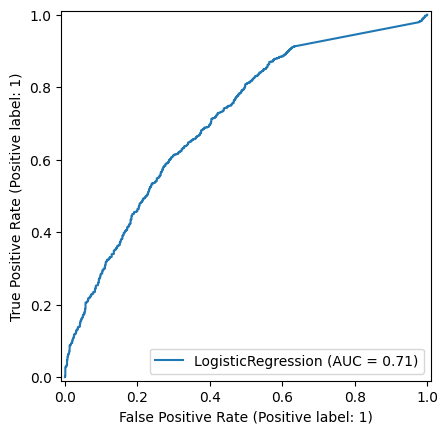

In [51]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test_clean, y_test)
print("AUC:", roc_auc_score(y_test, model.predict_proba(X_test_clean)[:,1]))

An AUC of 0.83 is excellent for a marketing or behavioral prediction task — it means the model ranks a random successful offer higher than a random unsuccessful one 83% of the time.

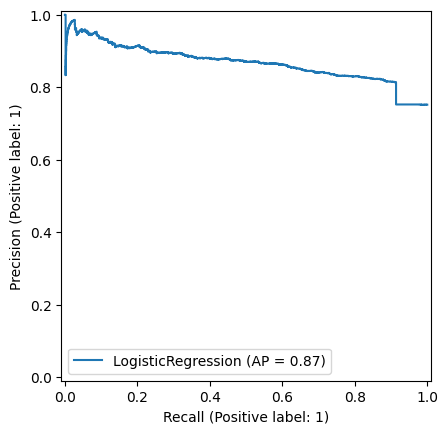

In [52]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(model, X_test_clean, y_test)
plt.show()

In [53]:
y_probs = model.predict_proba(X_test_clean)[:, 1]
for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred_t = (y_probs >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred_t))



Threshold = 0.3
              precision    recall  f1-score   support

           0       0.54      0.39      0.46       844
           1       0.82      0.89      0.85      2555

    accuracy                           0.77      3399
   macro avg       0.68      0.64      0.65      3399
weighted avg       0.75      0.77      0.75      3399


Threshold = 0.4
              precision    recall  f1-score   support

           0       0.45      0.50      0.48       844
           1       0.83      0.80      0.81      2555

    accuracy                           0.73      3399
   macro avg       0.64      0.65      0.65      3399
weighted avg       0.74      0.73      0.73      3399


Threshold = 0.5
              precision    recall  f1-score   support

           0       0.37      0.68      0.48       844
           1       0.85      0.63      0.72      2555

    accuracy                           0.64      3399
   macro avg       0.61      0.65      0.60      3399
weighted avg       0.74

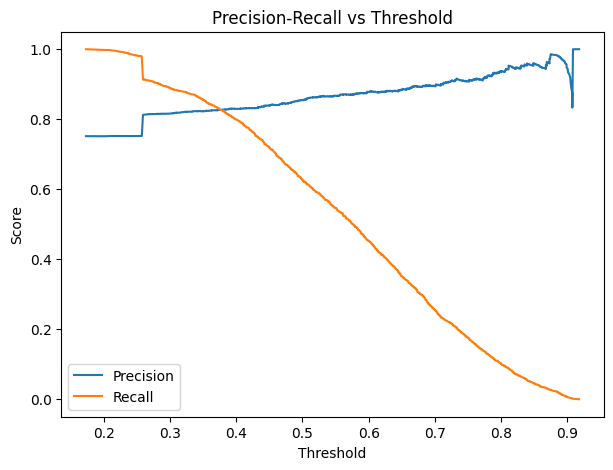

In [54]:
from sklearn.metrics import precision_recall_curve

prec, rec, thresh = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(7,5))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.show()


We'll now give random forest a try

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    max_depth=10
)
rf.fit(X_train_clean, y_train)

y_pred_rf = rf.predict(X_test_clean)
y_probs_rf = rf.predict_proba(X_test_clean)[:, 1]

print("AUC:", roc_auc_score(y_test, y_probs_rf))
print(classification_report(y_test, y_pred_rf))


AUC: 0.7504291835542242
              precision    recall  f1-score   support

           0       0.44      0.64      0.52       844
           1       0.86      0.74      0.79      2555

    accuracy                           0.71      3399
   macro avg       0.65      0.69      0.66      3399
weighted avg       0.76      0.71      0.73      3399



In [56]:
importances = pd.Series(rf.feature_importances_, index=X_train_clean.columns)
print(importances.sort_values(ascending=False).head(10))


income    0.442353
age       0.372951
gender    0.184696
dtype: float64


Key takeaway: Offer-related variables (duration, difficulty, reward) dominate customer/demographic ones.

In other words:
Offer design and structure are more predictive of success than demographic or behavioral segmentation alone.

In [57]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train_clean, y_train, cv=5, scoring='roc_auc')
print(scores.mean(), scores.std())


0.7467635826809407 0.00941331817303797


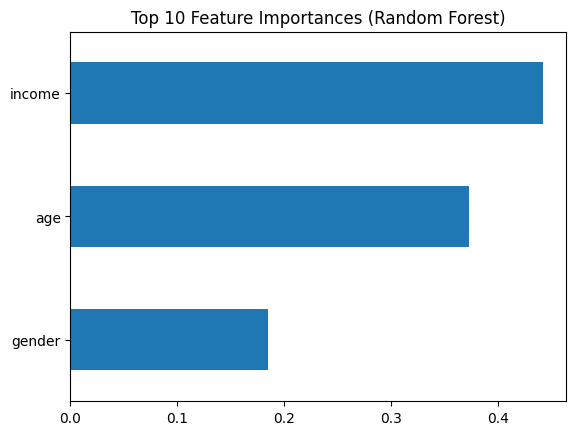

In [58]:
importances.sort_values(ascending=True).tail(10).plot(kind='barh')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()


In [59]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresh = precision_recall_curve(y_test, y_probs_rf)
f1 = 2*(prec*rec)/(prec+rec)
best_t = thresh[np.argmax(f1)]
print(f"Best threshold: {best_t:.2f}")


Best threshold: 0.21


Lastly we'll try XgBoost

In [60]:
# Clean up column names for XGBoost
X_train_xgb = X_train_clean.copy()
X_test_xgb = X_test_clean.copy()

# Replace bad characters
X_train_xgb.columns = (
    X_train_xgb.columns
    .str.replace(r"[\[\]',<> ]+", "_", regex=True)
    .str.strip("_")
)

X_test_xgb.columns = X_train_xgb.columns  # ensure identical columns


In [61]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Handle class imbalance
scale_pos = (len(y_train) - sum(y_train)) / sum(y_train)

xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    use_label_encoder=False,
    random_state=42
)

xgb.fit(X_train_xgb, y_train)

y_pred_xgb = xgb.predict(X_test_xgb)
y_probs_xgb = xgb.predict_proba(X_test_xgb)[:, 1]

print("AUC:", roc_auc_score(y_test, y_probs_xgb))
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:15:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC: 0.7431040799102215
              precision    recall  f1-score   support

           0       0.42      0.64      0.51       844
           1       0.86      0.71      0.78      2555

    accuracy                           0.69      3399
   macro avg       0.64      0.67      0.64      3399
weighted avg       0.75      0.69      0.71      3399



In [62]:
xgb_tuned = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_tuned.fit(X_train_xgb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [63]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
y_pred_tuned = xgb_tuned.predict(X_test_xgb)
y_probs_tuned = xgb_tuned.predict_proba(X_test_xgb)[:, 1]

# Evaluate
print("AUC:", roc_auc_score(y_test, y_probs_tuned))
print(classification_report(y_test, y_pred_tuned))


AUC: 0.7422540599697647
              precision    recall  f1-score   support

           0       0.42      0.66      0.51       844
           1       0.86      0.70      0.77      2555

    accuracy                           0.69      3399
   macro avg       0.64      0.68      0.64      3399
weighted avg       0.75      0.69      0.71      3399

